### **COLLABORATIVE FILTERING** ###

##### ***INFORMATION*** ######
- KNN Used to find 'similar' users.
- No cold start problem, no 'new' users in dataset


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
from fastai.vision.all import untar_data, URLs

In [3]:
# Load Data
path = untar_data(URLs.ML_100k)
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(path/'u.data', sep='\t', names=column_names)

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [4]:
# User-Item Matrix for Training
train_matrix = train_data.pivot(index='user_id', columns='item_id', values='rating')


In [5]:
# Clean Data
# Fill NaNs with 0 for similarity calculation
filled_matrix = train_matrix.fillna(0)
user_similarity = cosine_similarity(filled_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)


In [6]:
# Predict Function
def predict_rating(user_id, item_id, k=5):

    if item_id not in train_matrix.columns:
        return np.nan

    # Similarities for the current user
    similarities = user_similarity_df.loc[user_id]

    # Ratings of other users for this item
    item_ratings = train_matrix[item_id]

    # Only consider users who rated the item
    valid_users = item_ratings[item_ratings.notna()].index
    similarities = similarities[valid_users]
    item_ratings = item_ratings[valid_users]

    # Get top-k similar users
    top_k_users = similarities.sort_values(ascending=False)[:k]

    # Weighted average
    numerator = np.dot(top_k_users, item_ratings[top_k_users.index])
    denominator = np.sum(np.abs(top_k_users))

    # Preventing zero division
    if denominator == 0:
        return np.nan

    return numerator / denominator


In [7]:
# Predict for test set

true_ratings = []
pred_ratings = []

for _, row in test_data.iterrows():
    user = row['user_id']
    item = row['item_id']
    true = row['rating']
    pred = predict_rating(user, item)

    if not np.isnan(pred):
        true_ratings.append(true)
        pred_ratings.append(pred)

# Step 7: Error metrics
mae = mean_absolute_error(true_ratings, pred_ratings)
rmse = sqrt(mean_squared_error(true_ratings, pred_ratings))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.8411
RMSE: 1.0608


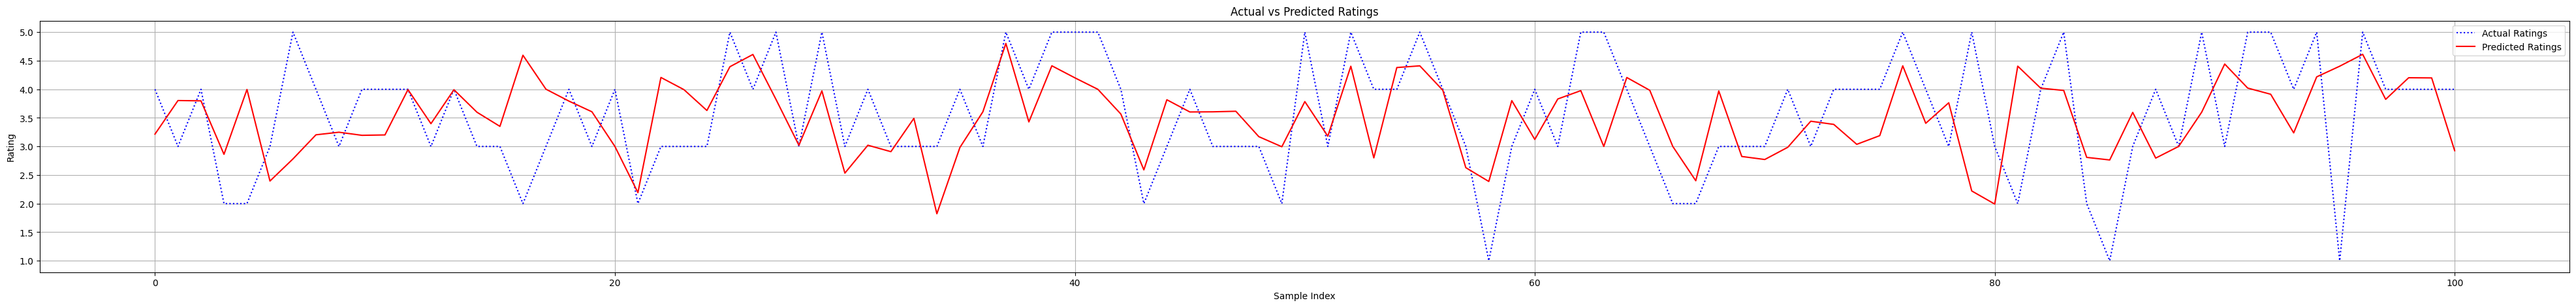

In [9]:
# Analyze Graphically

plt.figure(figsize=(50, 5))
plt.plot(true_ratings[0:101], label='Actual Ratings', linestyle='dotted', color='blue')
plt.plot(pred_ratings[0:101], label='Predicted Ratings' , linestyle='solid', color='red')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()